In [1]:
import pyarrow.parquet as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from category_encoders import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler
import torch
#from tensorboardX import SummaryWriter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.cm as cm

In [2]:
class PCAAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_layers, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.out_params = kwargs
        self.encoder = self._create_encoder()
        # Save encoder weights for the next model
        self.encoder_weights = self.encoder.state_dict().copy()
        self.decoder = self._create_decoder()


    def increase_latentdim(self):
        with torch.no_grad():
            # Increase size of the bottleneck
            self.hidden_layers[-1] += 1
            # Create new encoder
            self.encoder = self._create_encoder()
            # Copy weights from the old encoder
            self.copy_encoder_weights()
            # Create a new decoder
            self.decoder = self._create_decoder()


    def copy_encoder_weights(self):
        # Copy weights from the old encoder
        new_state_dict = self.encoder.state_dict().copy()
        for param in new_state_dict.keys():
            if param.endswith('.weight') or param.endswith('.bias'):
                if new_state_dict[param].size() != self.encoder_weights[param].size():
                    oldsize = tuple(slice(None, dim) for dim in self.encoder_weights[param].size())
                    new_state_dict[param][oldsize] = self.encoder_weights[param]
                else:
                    new_state_dict[param] = self.encoder_weights[param]
        # Loading the new state dict into the encoder
        self.encoder.load_state_dict(new_state_dict)


    def save_encoder_weights(self):
        # Saving new state dict as the encoder weigths
        self.encoder_weights = self.encoder.state_dict().copy()
            

    def _create_encoder(self):
        # Input layer
        encoder = nn.ModuleList()
        encoder.append(nn.Linear(self.input_size, self.hidden_layers[0]))
        encoder.append(nn.BatchNorm1d(self.hidden_layers[0]))
        # Creating the subsequent layers of the encoder
        for i in range(1, len(self.hidden_layers)):
            encoder.append(nn.Linear(self.hidden_layers[i-1], self.hidden_layers[i]))
            # Last layer in encoder should be linear no matter what
            if i != len(self.hidden_layers) -1:
                #encoder.append(nn.BatchNorm1d(self.hidden_layers[i]))
                encoder.append(nn.ReLU())
        return encoder


    def _create_decoder(self):
        # Layers before output layer
        decoder = nn.ModuleList()
        for i in reversed(range(1, len(self.hidden_layers))):
            decoder.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i-1]))
            #decoder.append(nn.BatchNorm1d(self.hidden_layers[i-1]))
            decoder.append(nn.ReLU())
        # Output layer
        decoder.append(nn.Linear(self.hidden_layers[0], self.input_size))
        return decoder


    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
            # if isinstance(layer, nn.BatchNorm1d):
            #     x = F.relu(x)
        return x


    def decode(self, x):
        for layer in self.decoder:
            x = layer(x)
            # if isinstance(layer, nn.BatchNorm1d):
            #     x = F.relu(x)
        # If an output activation function is specified
        if 'out_act' in self.out_params.keys():
            return self.out_params['out_act'](x)
        # If a separate activation function is specified for the nhumeric and the categoric outputs
        elif 'num_act' in self.out_params.keys():
            try:
                x_num = self.out_params['num_act'](x[:, :self.out_params['num_features']])
                x_cat = self.out_params['cat_act'](x[:, self.out_params['num_features']:])
                x = torch.cat((x_num, x_cat), dim=1)
                return x
            except KeyError as e:
                print(f"{e}: Specify all output parameters")
        # If no activation function is specified, use a linear one
        else:
            return x


    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [3]:
def train_model(model, goal_hidden_dim, optimizer, loss_func, epochs, trainloader, testloader, print_every):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    outer_steps = 0
    total_steps = 0
    total_train_losses, total_test_losses = [], []
    total_min_testloss = np.Inf
    
    while model.hidden_layers[-1] != goal_hidden_dim:
        if not outer_steps == 0:
            # Increasing latent space
            model.increase_latentdim()
            model.to(device)
            # Freezing encoder layers
            all_layers = len([layer for layer in model.encoder.parameters()])
            for i, layer in enumerate(model.encoder.parameters()):
                # Last layer in encoder is not freezed
                if i == all_layers - 2:
                    break
                else:
                    layer.requires_grad = False

        outer_steps += 1
        print(f"Training with hidden dim: {model.hidden_layers[-1]}")
        steps = 0
        train_losses, test_losses = [], []
        min_test_loss = np.Inf

        # Training loop
        for e in range(epochs):
            running_loss = 0
            # Only for printing it
            running_loss_ = 0
            for X, y in trainloader:
                steps += 1
                total_steps += 1
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat = model(X)
                loss = loss_func(y_hat, y)
                loss.backward()
                # TODO zero out gradient weights for all but the last added weight in the bottleneck layer of the encoder
                all_layers = len([layer for layer in model.encoder.parameters()])
                for i, layer in enumerate(model.encoder.parameters()):
                    # Last layer in encoder is not freezed
                    if i == all_layers - 2 or i == all_layers - 1:
                        layer.grad[0:-1] = torch.zeros_like(layer.grad[0:-1])
                    else:
                        pass
                optimizer.step()
                # Copy the weights from the old latent dim to the new
                #model.copy_encoder_weights()
                running_loss += loss.item()*X.size(0)
                running_loss_ += loss.item()

                if steps % print_every == 0:
                    print(f"Epoch: {e + 1}/{epochs}, Step {steps}, Train loss: {running_loss_/print_every:.3f}")
                    running_loss_ = 0

            # Running model on the test data  
            else:
                running_testloss = 0
                with torch.no_grad():
                    model.eval()
                    for X, y in testloader:
                        X, y = X.to(device), y.to(device)
                        y_hat = model(X)
                        test_loss = loss_func(y_hat, y)
                        running_testloss += test_loss.item()*X.size(0)
                model.train()

                train_losses.append(running_loss/len(trainloader.dataset))
                total_train_losses.append(running_loss/len(trainloader.dataset))
                test_losses.append(running_testloss/len(testloader.dataset))
                total_test_losses.append(running_testloss/len(testloader.dataset))

                # Saving model when test loss improved
                if test_losses[-1] <= min_test_loss:
                    print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_test_loss,test_losses[-1]))
                    # Saving the best weigths for the encoder to load back
                    model.save_encoder_weights()
                    torch.save(model.state_dict(), f'PCAAE_hidden_dim{model.hidden_layers[-1]}.pt')
                    min_test_loss = test_losses[-1]
                
                print(f'Epoch {e+1}/{epochs}, Train Loss: {running_loss/len(trainloader.dataset):.3f}, Test Loss: {running_testloss/len(testloader.dataset):.3f}')

    return total_train_losses, total_test_losses, total_steps              


In [23]:
# Dataset for tabular data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# Loading data
inputFeature = pd.read_csv('../../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

In [25]:
# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# Normalizing numerical features
for feature in numerical_features:
  train[feature] = (train[feature] - train[feature].min()) / (train[feature].max() - train[feature].min())
  test[feature] = (test[feature] - test[feature].min()) / (test[feature].max() - test[feature].min())

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

In [26]:
# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [27]:
model = PCAAutoencoder(X_train.shape[1], [32, 16, 1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 20
print_every = 40

In [31]:
model.state_dict().keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.1.weight', 'encoder.1.bias', 'encoder.1.running_mean', 'encoder.1.running_var', 'encoder.1.num_batches_tracked', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias'])

In [34]:
train_losses, test_losses, steps = train_model(model=model, goal_hidden_dim=2, 
                                         optimizer=optimizer, loss_func=criterion, epochs=epochs,
                                         trainloader=trainloader, testloader=testloader, print_every=40)

Training with hidden dim: 1
Epoch: 1/20, Step 40, Train loss: 0.024
Epoch: 1/20, Step 80, Train loss: 0.024
Epoch: 1/20, Step 120, Train loss: 0.023
Epoch: 1/20, Step 160, Train loss: 0.023
Epoch: 1/20, Step 200, Train loss: 0.023
Epoch: 1/20, Step 240, Train loss: 0.023
Epoch: 1/20, Step 280, Train loss: 0.022
Epoch: 1/20, Step 320, Train loss: 0.023
Epoch: 1/20, Step 360, Train loss: 0.023
Epoch: 1/20, Step 400, Train loss: 0.022
Epoch: 1/20, Step 440, Train loss: 0.022
Epoch: 1/20, Step 480, Train loss: 0.023
Test loss decreased (inf --> 0.022402).  Saving model ...
Epoch 1/20, Train Loss: 0.023, Test Loss: 0.022
Epoch: 2/20, Step 520, Train loss: 0.022
Epoch: 2/20, Step 560, Train loss: 0.022
Epoch: 2/20, Step 600, Train loss: 0.022
Epoch: 2/20, Step 640, Train loss: 0.022
Epoch: 2/20, Step 680, Train loss: 0.022
Epoch: 2/20, Step 720, Train loss: 0.022
Epoch: 2/20, Step 760, Train loss: 0.022
Epoch: 2/20, Step 800, Train loss: 0.022
Epoch: 2/20, Step 840, Train loss: 0.022
Epoch: 

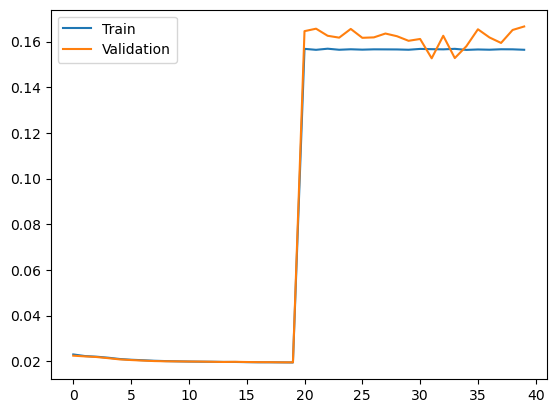

In [35]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend()
plt.show()

In [36]:
for par in model.encoder.parameters():
    print(par.grad)

None
None
None
None
None
None
tensor([[    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [  -24.0415,  -187.4760, -1068.5631,  -485.7148,  -306.7005,  -495.7879,
          -131.9182,  -141.3991,  -262.7227,   -36.3583,  -267.1220,   -44.7624,
          -292.0692,  -429.5790,  -386.0551,   -21.4532]], device='cuda:0')
tensor([   0.0000, -205.0350], device='cuda:0')


In [37]:
for par in model.parameters():
    print(par.requires_grad)

False
False
False
False
False
False
True
True
True
True
True
True
True
True


In [21]:
for par in model.encoder.parameters():
    print(par)

Parameter containing:
tensor([[-5.3316e-02, -1.0766e-02,  5.3088e-02,  ...,  1.3072e-02,
         -3.3415e-02,  1.7314e-03],
        [-3.1922e-02, -5.3540e-02, -4.4421e-02,  ..., -2.9399e-02,
          1.2919e-01, -1.8372e-01],
        [-2.5331e-02, -2.2117e-03,  2.8156e-02,  ..., -1.4062e-02,
         -5.1629e-01,  5.5479e-01],
        ...,
        [ 8.1333e-04,  1.4892e-02, -9.6123e-03,  ...,  6.7478e-03,
         -6.7952e-02,  3.8890e-02],
        [-3.9455e-02,  2.1686e-02,  2.1005e-02,  ..., -6.8418e-02,
          7.6207e-02, -1.0561e-01],
        [ 4.4607e-02, -4.9350e-05,  1.8621e-02,  ...,  3.4179e-02,
          2.7628e-01, -1.7743e-01]], device='cuda:0')
Parameter containing:
tensor([-0.0449,  0.0387,  0.0321, -0.0169, -0.0530, -0.0135, -0.0645, -0.0486,
        -0.0055, -0.0187, -0.0161,  0.0199, -0.0650,  0.0377, -0.0110, -0.0293,
         0.0071,  0.0197,  0.0210, -0.0186,  0.0302,  0.0053,  0.0565,  0.0151,
        -0.0592,  0.0636,  0.0283, -0.0166,  0.0552,  0.0393,  0.04

In [32]:
model

PCAAutoencoder(
  (encoder): ModuleList(
    (0): Linear(in_features=227, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=227, bias=True)
  )
)

In [39]:
a = torch.load("PCAAE_hidden_dim1.pt")

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_21564\2117146445.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = torch.load("PCAAE_hidden_dim1.pt")


In [46]:
b = torch.load("PCAAE_hidden_dim2.pt")

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_21564\152823176.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  b = torch.load("PCAAE_hidden_dim2.pt")


In [47]:
a

OrderedDict([('encoder.0.weight',
              tensor([[-0.1396,  0.0467, -0.0312,  ...,  0.0007, -0.2838,  0.3086],
                      [ 0.0017, -0.0041, -0.0094,  ...,  0.0116,  0.1530, -0.0595],
                      [ 0.0976,  0.0505,  0.0010,  ...,  0.1117, -0.0056, -0.0236],
                      ...,
                      [ 0.0509,  0.0253, -0.0583,  ...,  0.0244,  0.2125, -0.2639],
                      [ 0.0624,  0.0081, -0.0249,  ...,  0.0044,  0.0583, -0.0241],
                      [ 0.0240, -0.0344, -0.0038,  ...,  0.0660, -0.3947,  0.2876]],
                     device='cuda:0')),
             ('encoder.0.bias',
              tensor([-0.0289,  0.0653, -0.0274,  0.0476, -0.0014,  0.0434,  0.0270,  0.0249,
                      -0.0039,  0.0494,  0.0095,  0.0098, -0.0311,  0.0158,  0.0211, -0.0311,
                      -0.0307, -0.0588, -0.0579, -0.0377, -0.0281,  0.0350,  0.0059,  0.0590,
                       0.0149,  0.0271,  0.0285, -0.0099, -0.0548,  0.0600,  0.0

In [48]:
b

OrderedDict([('encoder.0.weight',
              tensor([[-0.1396,  0.0467, -0.0312,  ...,  0.0007, -0.2838,  0.3086],
                      [ 0.0017, -0.0041, -0.0094,  ...,  0.0116,  0.1530, -0.0595],
                      [ 0.0976,  0.0505,  0.0010,  ...,  0.1117, -0.0056, -0.0236],
                      ...,
                      [ 0.0509,  0.0253, -0.0583,  ...,  0.0244,  0.2125, -0.2639],
                      [ 0.0624,  0.0081, -0.0249,  ...,  0.0044,  0.0583, -0.0241],
                      [ 0.0240, -0.0344, -0.0038,  ...,  0.0660, -0.3947,  0.2876]],
                     device='cuda:0')),
             ('encoder.0.bias',
              tensor([-0.0289,  0.0653, -0.0274,  0.0476, -0.0014,  0.0434,  0.0270,  0.0249,
                      -0.0039,  0.0494,  0.0095,  0.0098, -0.0311,  0.0158,  0.0211, -0.0311,
                      -0.0307, -0.0588, -0.0579, -0.0377, -0.0281,  0.0350,  0.0059,  0.0590,
                       0.0149,  0.0271,  0.0285, -0.0099, -0.0548,  0.0600,  0.0

In [66]:
for i in a:
    if (a[i] == b[i]).all():
        print(f"{i} matches")
    else:
       print(f"{i} different")

encoder.0.weight matches
encoder.0.bias matches
encoder.1.weight matches
encoder.1.bias matches
encoder.1.running_mean different
encoder.1.running_var different
encoder.1.num_batches_tracked different
encoder.2.weight matches
encoder.2.bias matches
encoder.4.weight different
encoder.4.bias different
decoder.0.weight different
decoder.0.bias different
decoder.2.weight different
decoder.2.bias different
decoder.4.weight different
decoder.4.bias different


In [60]:
(a["encoder.0.bias"] == b["encoder.0.bias"]).all().item()

True

In [53]:
a["decoder.0.bias"]

tensor([-0.9990, -0.9761, -0.0871, -0.8815,  0.6756,  0.6615,  0.7377,  0.2528,
        -0.6931,  0.6946,  0.7773,  0.8097,  0.5125,  0.9604,  0.4772,  0.3078],
       device='cuda:0')

In [54]:
b["decoder.0.bias"]

tensor([ 0.0729, -0.1789,  0.5773, -0.5473, -0.3123,  0.1668, -0.3433, -0.5109,
        -0.1861, -0.3430,  0.6403,  0.6553,  0.0525, -0.2147,  0.0752,  0.5981],
       device='cuda:0')

In [63]:
for i in a:
    print(i)

encoder.0.weight
encoder.0.bias
encoder.1.weight
encoder.1.bias
encoder.1.running_mean
encoder.1.running_var
encoder.1.num_batches_tracked
encoder.2.weight
encoder.2.bias
encoder.4.weight
encoder.4.bias
decoder.0.weight
decoder.0.bias
decoder.2.weight
decoder.2.bias
decoder.4.weight
decoder.4.bias
